In [1]:
U_bc_dict = {
            'movingWall':{ "type":'fixedValue', "value":[1,0,0]},
            'fixedWalls':{ "type":'fixedValue', "value":[0,0,0]},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
    'movingWall':{ "type":'zeroGradient' },
    'fixedWalls':{ "type":'zeroGradient' },  
    'frontAndBack':{ "type":'empty'}    
}
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

In [ ]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh

dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse\case.foam'
vtk_file_reader = pv.POpenFOAMReader(dir)

# Get Mesh
mesh = gaus_green_vfm_mesh(vtk_file_reader)
mesh.add_bc_conditions(bc_dict)

# Get Ground Truth Data
vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
vtk_mesh = vtk_file_reader.read()[0]

U_gt = torch.tensor(vtk_mesh['U'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

Calculating face centers and areas for 4160 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 0.0, 'avg_non_orthogonality': 0.0, 'max_skewness': 2.3841880647523794e-06, 'avg_skewness': 2.975726260956435e-07}
 Found Patch "movingWall" with 32 Faces
 Found Patch "fixedWalls" with 96 Faces
 Found Patch "frontAndBack" with 2176 Faces
Boundary faces indexed: 2304/2176 patches found


## Final Product

In [5]:
from src.physics.operators import *

In [6]:
'''
Face Interpolater
Linear interpolates the values from cell centres to face centres
using specified weights according to distance to the face. 
'''
def interpolate_to_faces(self, field: torch.Tensor) -> torch.Tensor:
        
    # Get field shape
    assert len(field.shape) == 4
    batch_size = field.shape[0]
    time_size = field.shape[1]
    channel_size = field.shape[-1]
    
    # Initialize face values
    face_values = torch.zeros((batch_size, time_size, self.mesh.num_internal_faces, channel_size), device=field.device)
        
    # Interpolate for internal faces
    idx = self.mesh.internal_faces
    face_values = field[:,:,self.mesh.face_owners[idx],...]*(1 - self.internal_face_weights).reshape(1,1,-1,1)  + \
                                field[:,:,self.mesh.face_neighbors[idx],...]*(self.internal_face_weights).reshape(1,1,-1,1)
    return face_values

'''
Divergence Operator:
Takes the Gauss-Green Object and its mesh
Returns the Divergence calculated with advecting of the field i.e Nabla dot (UU),
Also returns the Gradient field to save computation.
'''
class Divergence_Operator():
    
    @staticmethod
    def caclulate(self, field: torch.Tensor, field_type:str = 'U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        div_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
        grad_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, channel_size, self.mesh.dim), dtype=field.dtype, device=self.device)
        
        div_field, grad_field = Divergence_Operator.internal_flux(self, div_field, grad_field, field)
        div_field, grad_field = Divergence_Operator.boundary_flux(self, div_field, grad_field, field, field_type)
        div_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)
        grad_field/= self.mesh.cell_volumes.reshape(1,1,-1,1,1)
        return div_field, grad_field.flatten(start_dim=-2)

    def internal_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor) -> torch.Tensor:
        face_values = interpolate_to_faces(self, field)
        idx = self.mesh.internal_faces
        divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[idx]).unsqueeze(-1) * face_values
        gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[idx])
        
        div_field.index_add_(2, self.mesh.face_owners[idx], divergence)
        div_field.index_add_(2, self.mesh.face_neighbors[idx], -divergence)
        grad_field.index_add_(2, self.mesh.face_owners[idx], gradient)
        grad_field.index_add_(2, self.mesh.face_neighbors[idx], -gradient)
        return div_field, grad_field
    
    @staticmethod
    def boundary_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor, field_type:str='U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]

        for patch_name, patch_faces in self.mesh.patch_face_keys.items():
            patch_type = self.bc_conditions[field_type][patch_name]['type']
            
            if patch_type in ('empty','noSlip'):
                continue
            if patch_type == 'fixedValue':
                field_value = torch.tensor(self.bc_conditions[field_type][patch_name]['value'], dtype=self.dtype, device=self.device)
                face_values = field_value.reshape(1, 1, 1, -1).repeat(batch_size, time_size, len(patch_faces), 1)
            elif patch_type == 'symmetryPlane':
                face_values = field[...,patch_faces,:] - 2*(torch.einsum('btfc,fc->btf', 
                                                                         field[...,face_values,:], 
                                                                         self.mesh.face_normal_unit_vectors[face_values,:]
                                                                         )).unsqueeze(-1) * self.mesh.face_normal_unit_vectors[face_values,:].unsqueeze(0)
            elif patch_type == 'zeroGradient':
                face_values = field[...,patch_faces,:]
            else:
                raise NotImplementedError(f'patch type {patch_type} not implemented')
            
            divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[patch_faces]).unsqueeze(-1) * face_values
            gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[patch_faces])
            div_field.index_add_(2, self.mesh.face_owners[patch_faces], divergence)
            grad_field.index_add_(2, self.mesh.face_owners[patch_faces], gradient)
    
        return div_field, grad_field

'''
Laplacian Operator:
Takes the Gauss-Green Object and its mesh + supplementary vectors (associated with orthogonality)
Returns the Laplacian calculated with specified implicitly/explicitly and/or non-orthogonal corrections
'''
class Laplacian_Operator():

    @staticmethod
    def caclulate(self, field:torch.tensor, field_type:str = 'U', correction_method:str=None, gradient_field:torch.tensor=None) -> torch.tensor:
        
        # initialize laplacian field
        batch_size = field.shape[0]
        time_size = field.shape[0]

        lap_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)

        lap_field = Laplacian_Operator.internal_flux(self, lap_field, field)
        lap_field = Laplacian_Operator.boundary_flux(self, lap_field, field, field_type)
        lap_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)

        if correction_method is not None:
            assert gradient_field is not None
            correction_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
            correction_field = Laplacian_Operator.internal_flux(self, correction_field, gradient_field, orthogonal=False)
            correction_field = Laplacian_Operator.boundary_flux(self, correction_field, field, field_type, orth_vector='k')

        return lap_field
    
    @staticmethod
    def internal_flux(self, lap_field:torch.tensor, field:torch.tensor, implicit:bool=True, orthogonal:bool=True, gradient_field:torch.tensor=None) -> torch.tensor:
        idx = self.mesh.internal_faces

        # Orthogonal
        if orthogonal:
            orth_vector = self.delta[idx]
            orth_vector_mag = self.delta_mag[idx]
        else:
            orth_vector = self.k_vector[idx]
            orth_vector_mag = self.k_vector_mag[idx]
        if implicit:
            # this might not hold if mesh is non-orthogonal
            face_gradients = field[:,:,self.mesh.face_neighbors[idx], :] - field[:,:,self.mesh.face_owners[idx],:]
            diffusion = face_gradients * (orth_vector_mag * self.mesh.face_areas_mag[idx]/self.d_mag[idx]).reshape(1, 1, -1, 1)
        else:
            assert gradient_field is not None
            # interpolate gradient to internal faces
            face_gradients = interpolate_to_faces(self, gradient_field).unflatten(dim=-1, sizes=(self.mesh.dim, self.mesh.dim))
            diffusion = torch.einsum('btfde,fe -> btfd',face_gradients, orth_vector)*self.mesh.face_areas_mag[idx]

        lap_field.index_add_(2, self.mesh.face_owners[idx], diffusion)
        lap_field.index_add_(2, self.mesh.face_neighbors[idx], -diffusion)

        return lap_field
    
    @staticmethod
    def boundary_flux(self, lap_field:torch.tensor, field:torch.tensor, field_type:str='U', orth_vector:str=None) -> torch.tensor:
        for patch_name, patch_faces in self.mesh.patch_face_keys.items():
            patch_type = self.bc_conditions[field_type][patch_name]['type']
            
            if patch_type in ('empty', 'symmetryPlane', 'zeroGradient'):
                continue
            else:
                if orth_vector is None:
                    orth_coefficient = (self.mesh.face_areas_mag[patch_faces]/self.d_mag[patch_faces])
                elif orth_vector == 'Delta':
                    orth_coefficient = torch.einsum('fd,fd -> f', self.mesh.face_normal_unit_vectors[patch_faces], self.delta[patch_faces])
                    orth_coefficient *= self.mesh.face_areas_mag[patch_faces]/(self.delta_mag[patch_faces]**2)
                elif orth_vector == 'k':
                    orth_coefficient = torch.einsum('fd,fd -> f', self.mesh.face_normal_unit_vectors[patch_faces], self.k_vector[patch_faces])
                    orth_coefficient *= self.mesh.face_areas_mag[patch_faces]/(self.k_vector_mag[patch_faces]**2)
                else:
                    raise KeyboardInterrupt(f'Orthogonal Vector string must be either "Delta", "k" or None. {orth_vector} is not accepted')

            if patch_type == 'fixedValue':
                field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
                bc_value = torch.tensor(self.bc_conditions[field_type][patch_name]['value'], dtype=self.dtype, device=self.device)
                diffusion = (bc_value.reshape(1,1,1,-1)-field_value)*orth_coefficient.reshape(1,1,-1,1)

            elif patch_type == 'noSlip':
                field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
                diffusion = (-field_value)*orth_coefficient.reshape(1,1,-1,1)

            else:
                raise NotImplementedError(f'patch type {patch_type} not implemented')
            
            lap_field.index_add_(2, self.mesh.face_owners[patch_faces], diffusion)
        
        return lap_field

In [9]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt)*0.01

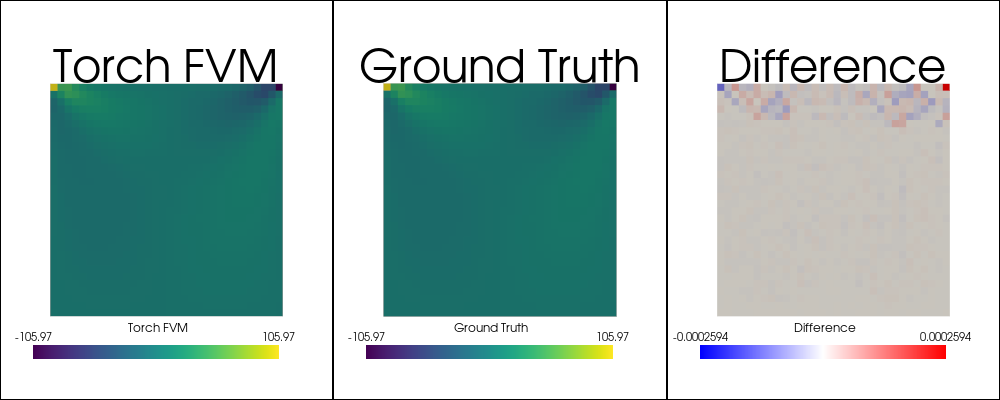

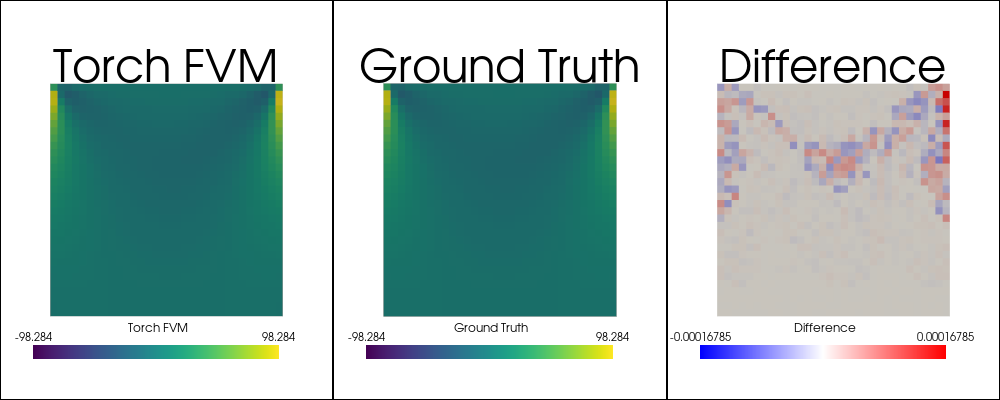

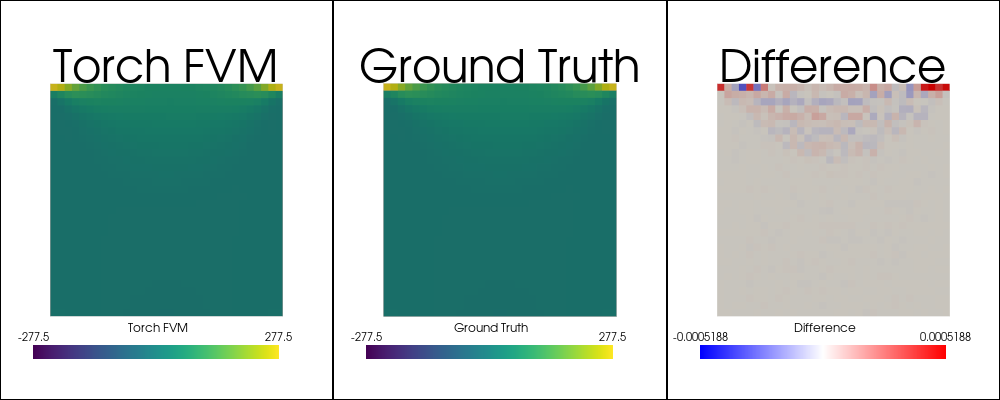

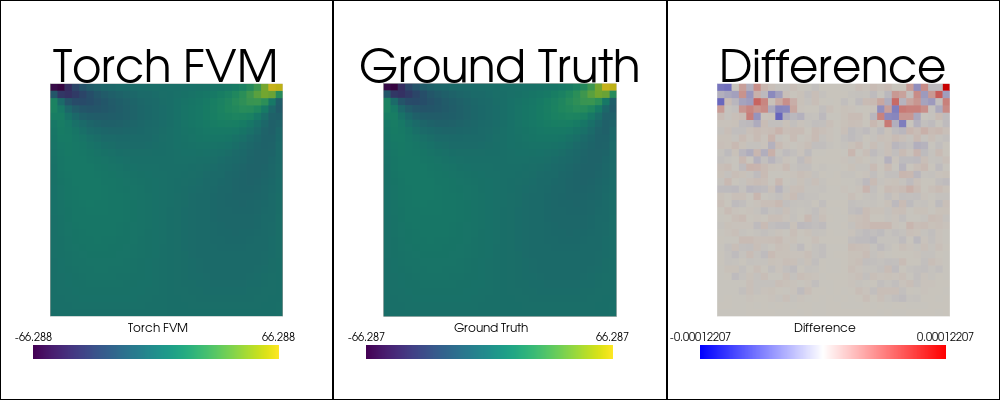

In [4]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
for i, j in enumerate([0,1,3,4]):
    plot_comparison(vtk_mesh, None, f'{names[i]}',
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    i=j, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

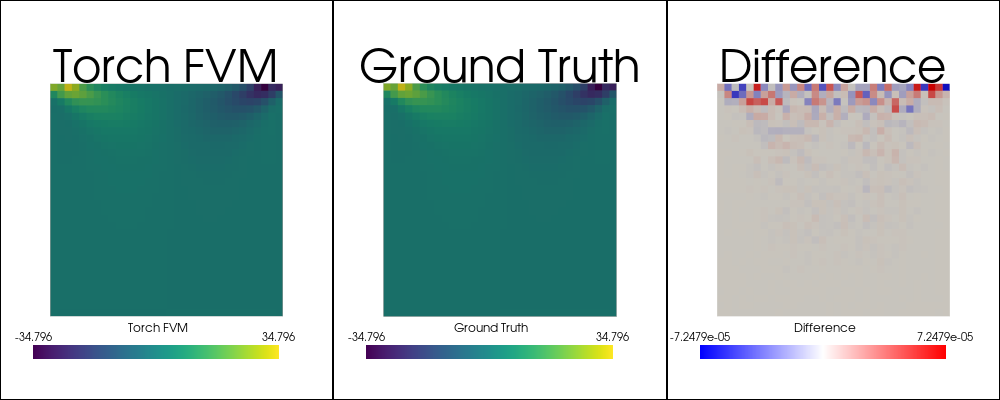

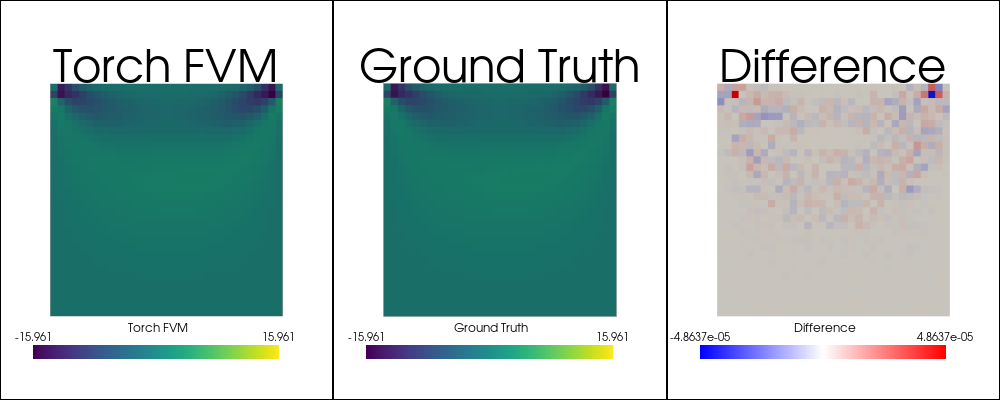

In [5]:
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    i=j, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

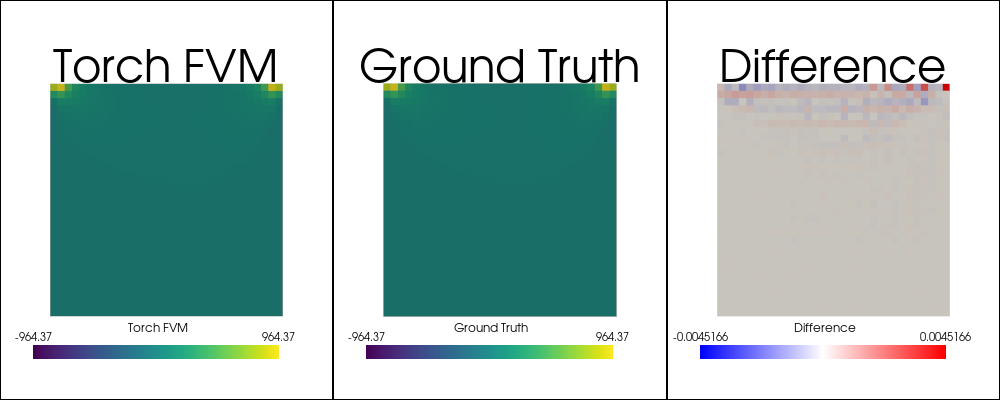

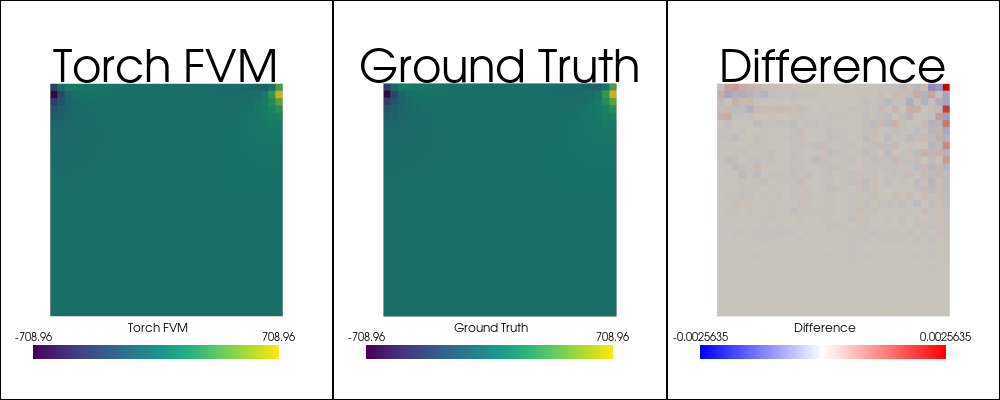

In [10]:
names = ['lapU', 'lapV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                    i=j, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

## Development

In [99]:
gradU_pred = mesh.calculate_gradients(field=U_gt, field_type='U')

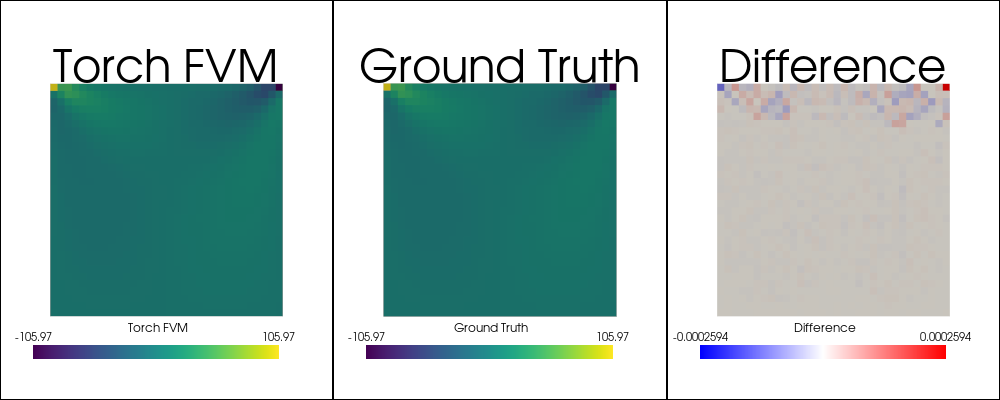

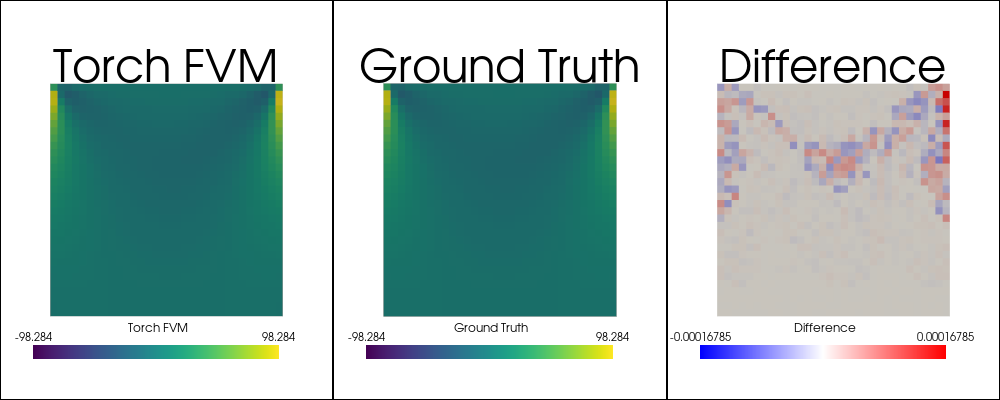

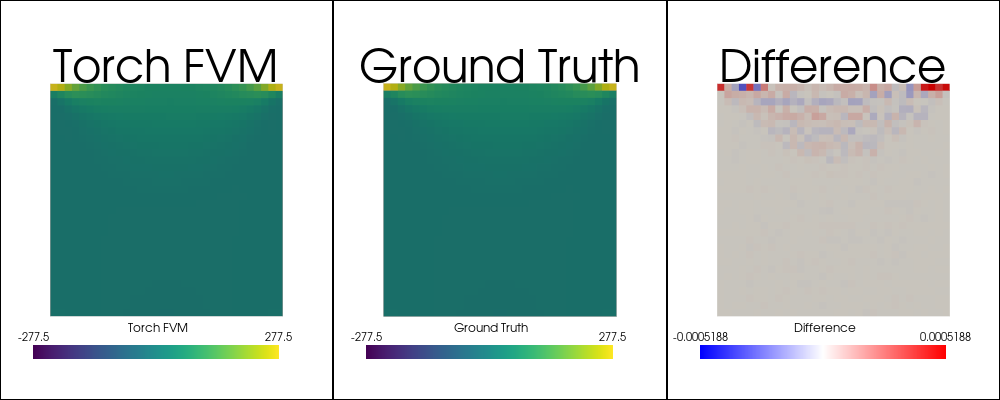

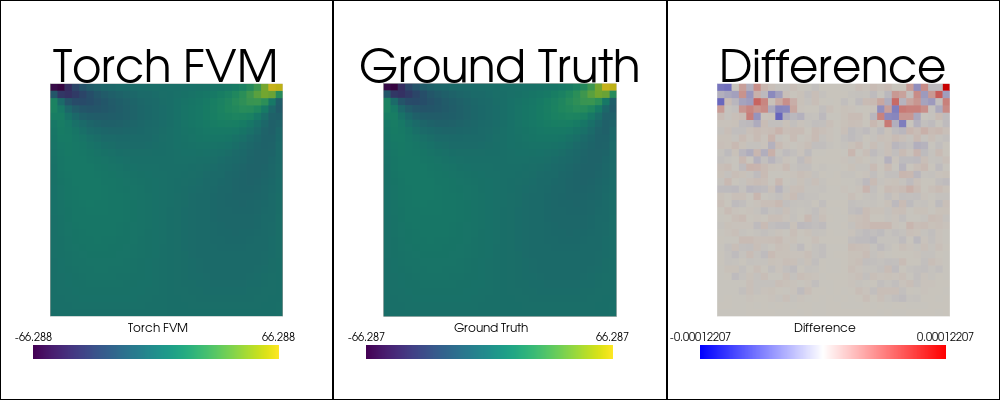

In [100]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
for i, j in enumerate([0,1,3,4]):
    plot_comparison(vtk_mesh, None, f'{names[i]}',
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    i=j, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

In [101]:
divU = mesh.calculate_divergence(U_gt, field_type='U')

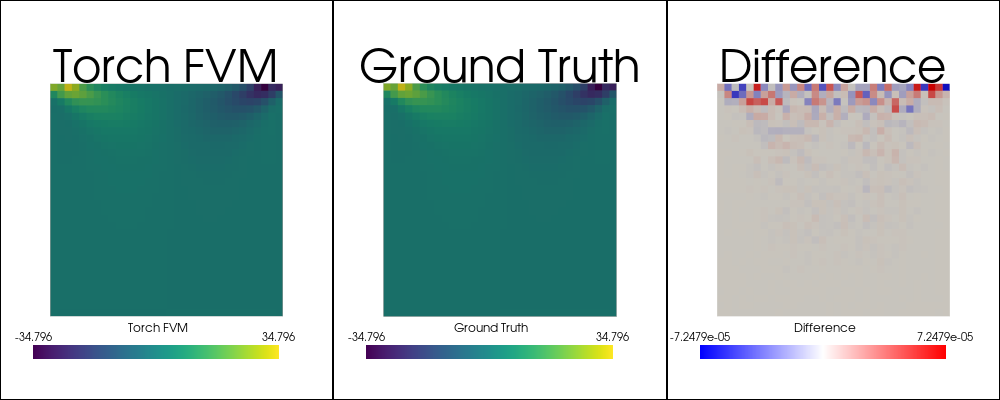

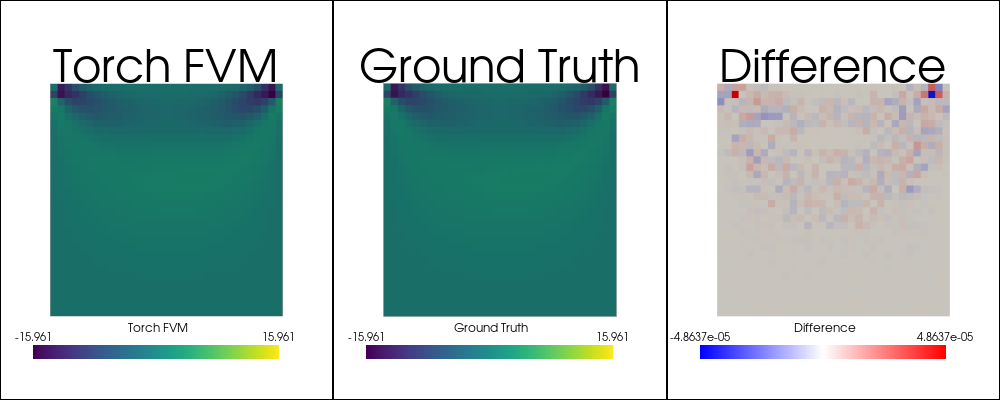

In [102]:
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                    prediction=divU.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    i=j, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

In [103]:
self = mesh 
field = U_gt
field_type='U'
grad_field_f=False
original_field=None
        
# Get field shape
assert len(field.shape) == 4
field_shape = field.shape
batch_size = field_shape[0]
time_size = field_shape[1]
channel_size = field_shape[-1]

# Initialize face values
face_values = torch.zeros((batch_size, time_size, self.mesh.num_faces, channel_size), device=field.device)

# Interpolate for internal faces
idx = self.mesh.internal_faces
face_values[:,:,idx,:] = field[...,self.mesh.face_owners[idx],:]*(1 - self.internal_face_weights).reshape(1,1,-1,1)  + \
                            field[...,self.mesh.face_neighbors[idx],:]*(self.internal_face_weights).reshape(1,1,-1,1)

# Apply hard boundary conditions for faces
if self.boundaries is not None:
    for patch_name, patch_faces in self.mesh.patch_face_keys.items():
        face_value = self.apply_bc_conditions(patch_name, 
                                                bc_face_idx=patch_faces, 
                                                field=field, 
                                                field_type=field_type, 
                                                grad_field_f=grad_field_f, 
                                                original_field=original_field)
        
        if patch_name == 'movingWall':
            movingWall_value = face_value
            movingWall__idx = patch_faces
        if face_value is not None:
            face_values[:,:,patch_faces,:] = face_value

In [104]:
print(f'Are these tensors the same? {torch.allclose(movingWall_value, face_values[:,:,movingWall__idx,:])}')
print(f'Is the first channel all ones? {torch.allclose(face_values[:,:,movingWall__idx,:][:, :, :, 0], torch.ones_like(face_values[:,:,movingWall__idx,:][:, :, :, 0]))}')
print(f'Is the second channel all zeros? {torch.allclose(face_values[:,:,movingWall__idx,:][:, :, :, 1], torch.zeros_like(face_values[:,:,movingWall__idx,:][:, :, :, 1]))}')
print(f'Is the third channel all zeros? {torch.allclose(face_values[:,:,movingWall__idx,:][:, :, :, 2], torch.zeros_like(face_values[:,:,movingWall__idx,:][:, :, :, 2]))}')

Are these tensors the same? True
Is the first channel all ones? True
Is the second channel all zeros? True
Is the third channel all zeros? True


In [105]:
cell_centers = mesh.mesh.cell_centers
y_max = cell_centers[:, 1].max()
# Find all indices where y is maximal
y_max_indices = np.where(cell_centers[:, 1] == y_max)[0]
# Among those, find the one with minimal x
x_min_idx = y_max_indices[np.argmin(cell_centers[y_max_indices, 0])]
x_max_idx = y_max_indices[np.argmax(cell_centers[y_max_indices, 0])]
print(f'Index Left Corner: {x_min_idx}, right corner: {x_max_idx}')
print(f'Coordinates: {cell_centers[x_min_idx]} and {cell_centers[x_max_idx]}')
print('du/dx', gradU_gt[0,0,x_min_idx,0], 'vs', gradU_pred[0,0,x_min_idx,0])
print('Div', divU_gt[0,0,x_min_idx], 'vs', divU[0,0,x_min_idx])

Index Left Corner: 992, right corner: 1022
Coordinates: tensor([0.0016, 0.0984, 0.0050]) and tensor([0.0953, 0.0984, 0.0050])
du/dx tensor(103.2970) vs tensor(103.2971)
Div tensor([25.2060, -0.3928,  0.0000]) vs tensor([25.2060, -0.3929,  0.0000])


In [106]:
# Use Ofpp to get the owner array from the OpenFOAM case directory
dir_2 = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse'
ofpp_mesh = Ofpp.FoamMesh(dir_2)
ofpp_face_idx = np.where(ofpp_mesh.owner == x_min_idx)
torch_face_idx = torch.where(mesh.mesh.face_owners == x_min_idx)
ofpp_face_neighbour_idx = np.where(ofpp_mesh.neighbour == x_min_idx)
torch_face_neighbour_idx = torch.where(mesh.mesh.face_neighbors == x_min_idx)
print('in Openfoam', ofpp_face_idx)
print('in Torch FVM', torch_face_idx)

in Openfoam (array([1953, 1984, 2047, 2143, 3167], dtype=int64),)
in Torch FVM (tensor([4031, 4032, 4033, 4034, 4035]),)


In [107]:
def sort_faces_by_vertex(mesh_points, mesh_faces, owner_indices, neighbour_indices=None):
    if neighbour_indices is not None:
        owner_indices = torch.cat([owner_indices,neighbour_indices])
    face_centres = []
    for face in owner_indices:
        face_centres.append(torch.mean(mesh_points[mesh_faces[face]],dim=0).unsqueeze(0))
        #maxes, mins = find_cell_bounds(torch.tensor(mesh_points[mesh_faces[face]]), maxes, mins)
    face_centres_of =torch.cat(face_centres, dim=0)
    indices = torch.argsort(face_centres_of[:, 2])               # sort by third column
    indices = indices[torch.argsort(face_centres_of[indices, 1])] # stable sort by second
    indices = indices[torch.argsort(face_centres_of[indices, 0])] # stable sort by first
    return owner_indices[indices]

ofpp_owner_indices = sort_faces_by_vertex(mesh_points=torch.tensor(ofpp_mesh.points), 
                                     mesh_faces=torch.tensor(ofpp_mesh.faces), 
                                     owner_indices=torch.tensor(ofpp_face_idx)[0],
                                     neighbour_indices=torch.tensor(ofpp_face_neighbour_idx)[0])
torch_owner_indices = sort_faces_by_vertex(mesh_points=mesh.mesh.vertices, 
                                     mesh_faces=mesh.mesh.faces, 
                                     owner_indices=torch_face_idx[0],
                                     neighbour_indices=torch_face_neighbour_idx[0]
                                     )
print(ofpp_owner_indices, torch_owner_indices)

tensor([2047, 1891, 2143, 3167, 1984, 1953]) tensor([4033, 3906, 4032, 4031, 4035, 4034])


In [108]:
# Read an internal field (e.g., velocity 'U') from the OpenFOAM case using Ofpp
ofpp_phi = Ofpp.parse_internal_field(dir_2 + '/102/phiAll')
internal_phi_patch = ofpp_phi[[i.item() for i in ofpp_owner_indices if i.item() < ofpp_phi.shape[0]]]
print('we only have these', [i.item() for i in ofpp_owner_indices if i.item() < ofpp_phi.shape[0]])
# Pad ofpp_phi with zeros at the end to match mesh.mesh.num_faces + ofpp_phi.shape[0]
padded_ofpp_phi = torch.nn.functional.pad(torch.tensor(ofpp_phi), (0, mesh.mesh.num_faces-ofpp_phi.shape[0]))
padded_ofpp_phi.shape
face_flux = torch.einsum('btfd,fd->btf', face_values, mesh.mesh.face_areas).squeeze(0).squeeze(0)  

we only have these [1891, 1953]


In [109]:
def plot_normal_vector2(ax, start_coord, normal, color='red'):
    # Plot normal vector (arrow from center)
    start = start_coord.numpy()
    vector = normal.numpy()
    ax.quiver(*start, *vector, length=0.006, normalize=True, color=color, linewidth=2)
    return ax

0 tensor([-1.,  0.,  0.]) tensor(0.) tensor(0., dtype=torch.float64)
1 tensor([0., 1., 0.]) tensor(5.9849e-06) tensor(5.9849e-06, dtype=torch.float64)
2 tensor([0., 0., 1.]) tensor(0.) tensor(0., dtype=torch.float64)
3 tensor([ 0.,  0., -1.]) tensor(0.) tensor(0., dtype=torch.float64)
4 tensor([0., 1., 0.]) tensor(0.) tensor(0., dtype=torch.float64)
5 tensor([1., 0., 0.]) tensor(1.0088e-05) tensor(1.0088e-05, dtype=torch.float64)


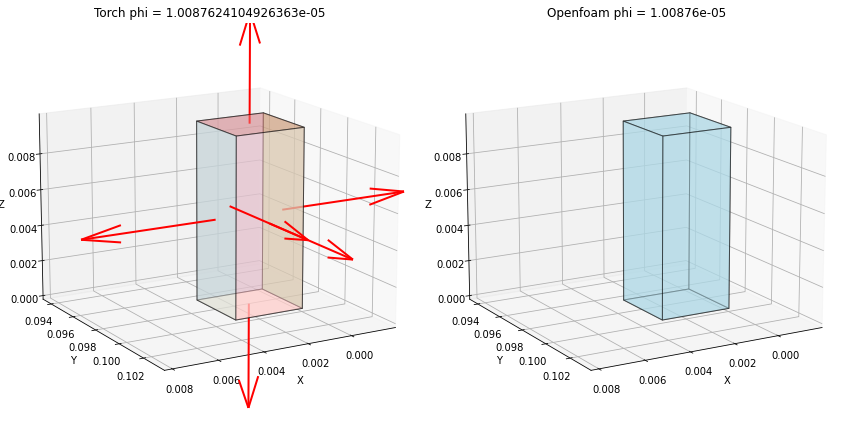

In [110]:
from utils.mesh_checks import *
import warnings

indx = 4 # select face here

# Create plot
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')

face_idx_vtk = torch_owner_indices[indx]
face_idx_of = ofpp_owner_indices[indx]
#n_vec_gt = torch.nn.functional.normalize(Sf_gt, dim=-1)
#fig = plt.figure()
colours = ['lightgreen', 'lightblue', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
for i in range(6):
    face_idx_vtk = torch_owner_indices[i]
    ax1 = plot_face_3d(ax1, mesh.mesh.vertices[mesh.mesh.faces[face_idx_vtk]], 
                    color=colours[i], elev=30, azim=-60, show_vertices=False)
    ax1 = plot_normal_vector2(ax1, 
                            mesh.mesh.face_centers[face_idx_vtk], 
                            mesh.mesh.face_normal_unit_vectors[face_idx_vtk], color='red')
    
    face_idx_of = ofpp_owner_indices[i]
    print(i, mesh.mesh.face_normal_unit_vectors[face_idx_vtk], face_flux[face_idx_vtk], padded_ofpp_phi[face_idx_of])
    ax2 = plot_face_3d(ax2, ofpp_mesh.points[ofpp_mesh.faces[face_idx_of]], 
                        color='lightblue', elev=30, azim=-60, show_vertices=False)

face_center = mesh.mesh.face_centers[face_idx_vtk].numpy()
margin = 0.005

x = [face_center[0]-margin, face_center[0]+margin]
y = [face_center[1]-margin, face_center[1]+margin]
z = [face_center[2]-margin, face_center[2]+margin]
ax1.set_xlim([x[0], x[1]])
ax1.set_ylim([y[0], y[1]])
ax1.set_zlim([z[0], z[1]])
ax2.set_xlim([x[0], x[1]])
ax2.set_ylim([y[0], y[1]])
ax2.set_zlim([z[0], z[1]])

ax1.set_title(f"Torch phi = {face_flux[face_idx_vtk]}")
ax2.set_title(f"Openfoam phi = {padded_ofpp_phi[face_idx_of]}")
ax1.view_init(elev=15, azim=60)
ax2.view_init(elev=15, azim=60)
plt.tight_layout()
plt.show()

since the actual face fluxes are already at a precision of e-06, and we demonstrated that the error of the mesh was at that precision too. We could potentially state that this is the cause of the error. Can we get the mesh to be more accurate.

# Mesh Validation ... again

In [111]:
ofpp_C = Ofpp.parse_internal_field(dir_2 + '/102/C')
torch_C = mesh.mesh.cell_centers.numpy()

dif = abs(ofpp_C - torch_C)
('torch to numpy')
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}')  

mean difference: 9.481421630383859e-10
max difference: 4.470348355378739e-09


Cell centers are ok

In [112]:
ofpp_p = ofpp_mesh.points
torch_p = mesh.mesh.vertices.numpy()

dif = abs(ofpp_p - torch_p)
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}')  

mean difference: 7.286893594927437e-10
max difference: 2.980232241545089e-09


Vertices are ok

In [113]:
ofpp_V = Ofpp.parse_internal_field(dir_2 + '/102/Vc')
torch_V = mesh.mesh.cell_volumes.numpy()
dif = abs(ofpp_p - torch_p)
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}')  

mean difference: 7.286893594927437e-10
max difference: 2.980232241545089e-09


check torch to numpy change

In [114]:
ofpp_V_torch = torch.tensor(Ofpp.parse_internal_field(dir_2 + '/102/Vc'))
ofpp_V_torch_back = ofpp_V_torch.numpy()
dif = abs(ofpp_V - ofpp_V_torch_back)
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}') 

mean difference: 0.0
max difference: 0.0


variables left to check are:
- normal vectors
- face areas

These are collected in one calculation. Lets see if it is accurate

We need to reorder these first

In [115]:
Ofpp_sorted_faces = np.array([np.sort(face) for face in ofpp_mesh.faces])
def reorder_B_to_match_A(A, B):
    # Build a mapping from tuple(row) in B to its index
    row_to_index = {tuple(np.sort(row)): i for i, row in enumerate(B)}

    # Use this mapping to reorder B
    indices = [row_to_index[tuple(row)] for row in A]

    # Reorder B accordingly
    return indices

# Example usage
indices_reorder = reorder_B_to_match_A(Ofpp_sorted_faces, mesh.mesh.faces)

In [116]:
ofpp_Sf =  torch.tensor(Ofpp.parse_internal_field(dir_2 + '/102/Sf'))
torch_Sf = mesh.mesh.face_areas[indices_reorder][:len(ofpp_Sf)].numpy()
dif = abs(ofpp_Sf - torch_Sf)
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}') 
dif_abs = abs((ofpp_Sf - torch_Sf)/(ofpp_Sf+ 1e-16))  # Avoid division by zero
print(f'mean difference: {dif_abs.mean()*100}%')
print(f'max difference: {dif_abs.max()*100}%')

mean difference: 6.231857696507447e-12
max difference: 4.514004103774345e-11
mean difference: 1.9941944628760017e-05%
max difference: 0.00014444813132031683%


In [117]:
ofpp_Sfmag = torch.norm(torch.tensor(ofpp_Sf), dim=-1, keepdim=False).numpy()
torch_Sfmag = torch.norm(torch.tensor(torch_Sf), dim=-1, keepdim=False).numpy()
dif = abs(ofpp_Sfmag - torch_Sfmag)
print(f'mean difference: {dif.mean()}')
print(f'max difference: {dif.max()}') 

mean difference: 1.869557308952234e-11
max difference: 4.514004103774345e-11


<ipython-input-117-4a23134c6ce0>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ofpp_Sfmag = torch.norm(torch.tensor(ofpp_Sf), dim=-1, keepdim=False).numpy()


So the geometry all has an error of e-11. It can't be the issue. Lets try recalculating the flux

In [118]:
print(ofpp_owner_indices, torch_owner_indices)
print('we only have these', [i.item() for i in ofpp_owner_indices if i.item() < ofpp_phi.shape[0]])

tensor([2047, 1891, 2143, 3167, 1984, 1953]) tensor([4033, 3906, 4032, 4031, 4035, 4034])
we only have these [1891, 1953]


In [119]:
face_values_1 = face_values[0,0,indices_reorder[:len(ofpp_Sf)],:][1891]
face_values_2 = face_values[0,0,indices_reorder[:len(ofpp_Sf)],:][1953]

In [120]:
ofpp_Uf =  torch.tensor(Ofpp.parse_internal_field(dir_2 + '/102/Uf'))
torch_Uf = face_values[0,0,indices_reorder][:len(ofpp_Sf)].numpy()
dif = abs(ofpp_Uf - torch_Uf)
print(f'mean difference: {dif.mean()} relative to mean: {dif.mean()/ofpp_Uf.mean():.6f}%')
print(f'max difference: {dif.max()} relative to max: {dif.max()/ofpp_Uf.max():.6f}%') 
print('absolute relative differences')
dif_rel = dif / (ofpp_Uf + 1e-8)  # Avoid division by zero
print(f'mean difference: {dif_rel.mean()*100:.7f}%')
print(f'max difference: {dif_rel.max()*100:.7f}%')

mean difference: 7.920162466176996e-08 relative to mean: -0.000041%
max difference: 8.68011474586261e-07 relative to max: 0.000001%
absolute relative differences
mean difference: -0.0000256%
max difference: 0.0019112%


In [121]:
# Method 1 
face_flux1 = torch.einsum('d,d->', face_values_1, mesh.mesh.face_areas[indices_reorder[:len(ofpp_Sf)],:][1891])
face_flux2 = torch.einsum('d,d->', face_values_2, mesh.mesh.face_areas[indices_reorder[:len(ofpp_Sf)],:][1953])

# Method 2
face_flux1 = torch.dot(ofpp_Uf[1891].to(torch.float32), mesh.mesh.face_areas[indices_reorder[:len(ofpp_Sf)],:][1891])
face_flux2 = torch.dot(ofpp_Uf[1953].to(torch.float32), mesh.mesh.face_areas[indices_reorder[:len(ofpp_Sf)],:][1953])

# Method 3
face_flux1 = torch.dot(ofpp_Uf[1891], ofpp_Sf[1891])
face_flux2 = torch.dot(ofpp_Uf[1953], ofpp_Sf[1953])

Method 1 and 2 are both giving a big error. Suggesting either mesh areas are wrong. Or the precision is to blame

In [122]:
ofpp_Uf[1953] - ofpp_Uf[1953].to(torch.float32).to(torch.float64)

tensor([-3.9539e-09,  2.4171e-09,  0.0000e+00], dtype=torch.float64)

Conversion between float32 and float64 does cause a e-09 error (this could be exacerbated with multiplications down the line)

In [123]:
print(face_flux1, 'vs', padded_ofpp_phi[1891])
print(face_flux2, 'vs', padded_ofpp_phi[1953])

dif_rel1 = (face_flux1 - padded_ofpp_phi[1891])/ (padded_ofpp_phi[1891] + 1e-16)  # Avoid division by zero
dif_rel2 = (face_flux2 - padded_ofpp_phi[1953])/ (padded_ofpp_phi[1953] + 1e-16)  # Avoid division by zero
print(f'1. mean difference: {(face_flux1 - padded_ofpp_phi[1891]).mean():.7f}')
print(f'2. mean difference: {(face_flux2 - padded_ofpp_phi[1953]).mean():.7f}')
print(f'1. mean difference: {dif_rel1.mean()*100:.7f}% max difference: {dif_rel1.max()*100:.7f}%')
print(f'2. mean difference: {dif_rel2.mean()*100:.7f}% max difference: {dif_rel2.max()*100:.7f}%')

tensor(5.9849e-06, dtype=torch.float64) vs tensor(5.9849e-06, dtype=torch.float64)
tensor(1.0088e-05, dtype=torch.float64) vs tensor(1.0088e-05, dtype=torch.float64)
1. mean difference: 0.0000000
2. mean difference: 0.0000000
1. mean difference: 0.0002715% max difference: 0.0002715%
2. mean difference: 0.0002478% max difference: 0.0002478%


**Method 3 also causes the mismatch! So it is the dot product itself that is wrong**

So either it is the dot product or it is the face_values. Lets look at what interpolation Openfoam produces:

advective flux

In [124]:
advective_face_flux1 = face_flux1*face_values[0,0,indices_reorder][:len(ofpp_Sf)][1891]
advective_face_flux2 = face_flux2*face_values[0,0,indices_reorder][:len(ofpp_Sf)][1953]
advective_face_flux1_of = padded_ofpp_phi[1891]*face_values[0,0,indices_reorder][:len(ofpp_Sf)][1891]
advective_face_flux2_of = padded_ofpp_phi[1953]*face_values[0,0,indices_reorder][:len(ofpp_Sf)][1953]
print(advective_face_flux1, 'vs', advective_face_flux1_of)
print(advective_face_flux2, 'vs', advective_face_flux2_of)
print(100*(advective_face_flux1_of-advective_face_flux1)/(advective_face_flux1_of+1e-12), '%')
print(100*(advective_face_flux2_of-advective_face_flux2)/(advective_face_flux2_of+1e-12), '%')

tensor([7.9480e-07, 1.1462e-06, 0.0000e+00])

 vs tensor([7.9479e-07, 1.1462e-06, 0.0000e+00])
tensor([3.2563e-06, 1.1078e-06, 0.0000e+00]) vs tensor([3.2563e-06, 1.1078e-06, 0.0000e+00])
tensor([-0.0003, -0.0003,  0.0000]) %
tensor([-0.0003, -0.0002,  0.0000]) %


So consistently a 24% difference in advective flux per face. Purely because of the mean 75% difference in face flux. The face values had an error of 0.0019% and the area vector had an error of 0.00014%

## Divergence from Gradient

In [125]:
gradU_pred.shape

torch.Size([1, 1, 1024, 9])

u*du/dx + v*dv/dy

In [126]:

Ux = gradU_gt[...,0]
Uy = gradU_gt[...,4]
#Uz = gradU_pred[...,2]
divergence = (U_gt[...,0]*Ux + U_gt[...,1]*Uy)#+ U_gt[...,2]*Uz
divergence = divergence.unsqueeze(-1)

In [127]:
gradU_pred.shape

torch.Size([1, 1, 1024, 9])

In [128]:
gradU_gt.shape

torch.Size([1, 1, 1024, 9])

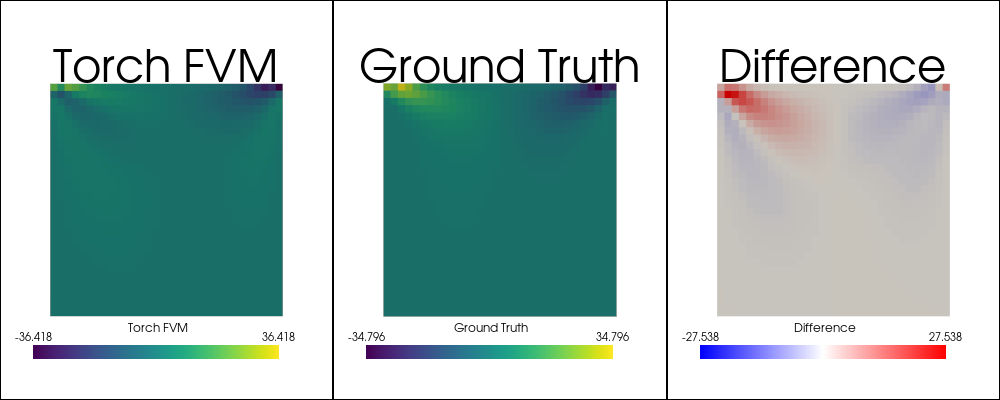

In [129]:
names = ['divU', 'divV']
plot_comparison(vtk_mesh, None, f'Uncorrected_{names[0]}',
                prediction=divergence.squeeze(0).squeeze(0).numpy(),
                ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                i=0, interactive = True, 
                point_label=False,
                #clims3=[-0.000001, 0.000001]
                )

This is also incorrect. And this was the divergence calculated off the correct gradient calculation.

## Laplacian

compare values

In [130]:
channel = 0
for i in ['Minimum', 'Orthogonal', 'Over-Relaxed', None]:
        for j in [True, False]:
            mesh.limiting_coefficient = 0.0
            mesh.correction_method = i
            mesh.implicit_orthogonality = j
            lapU = mesh.calculate_laplacian(U_gt, field_type='U')#*0.01333
            dif = (lapU_gt - lapU).abs()[...,channel]
            stats = [dif.mean(), dif.max(), dif.min()] 
            print(f'Method: {mesh.correction_method or "None" :13}, ',
                  f'Implicit: {mesh.implicit_orthogonality:3}, ',
                  f'Any NA: {torch.any(torch.isnan(lapU))}, ',
                  f'| Difference | mean: {stats[0]:.4f}, max: {stats[1]:.4f}, min: {stats[2]:.4f}')

Method: Minimum      ,  Implicit:   1,  Any NA: False,  | Difference | mean: 5510.0742, max: 80330.0938, min: 0.1568
Method: Minimum      ,  Implicit:   0,  Any NA: False,  | Difference | mean: 60.6358, max: 7495.8706, min: 0.0074
Method: Orthogonal   ,  Implicit:   1,  Any NA: False,  | Difference | mean: 5510.0742, max: 80330.0938, min: 0.1568
Method: Orthogonal   ,  Implicit:   0,  Any NA: False,  | Difference | mean: 60.6358, max: 7495.8706, min: 0.0074
Method: Over-Relaxed ,  Implicit:   1,  Any NA: False,  | Difference | mean: 5510.0742, max: 80330.0938, min: 0.1568
Method: Over-Relaxed ,  Implicit:   0,  Any NA: False,  | Difference | mean: 60.6358, max: 7495.8706, min: 0.0074
Method: None         ,  Implicit:   1,  Any NA: False,  | Difference | mean: 5510.0742, max: 80330.0938, min: 0.1568
Method: None         ,  Implicit:   0,  Any NA: False,  | Difference | mean: 60.6358, max: 7495.8706, min: 0.0074


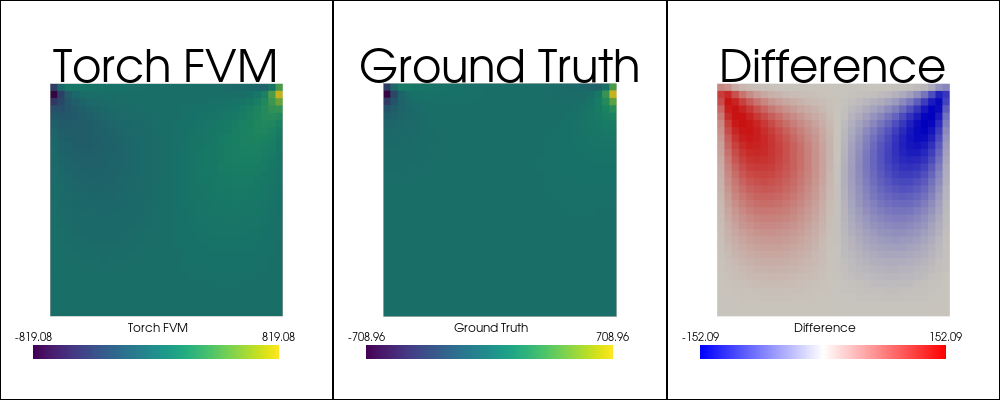

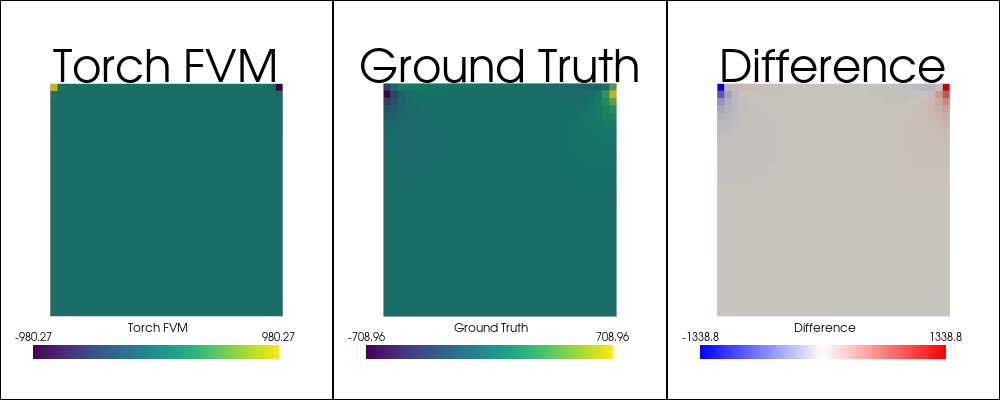

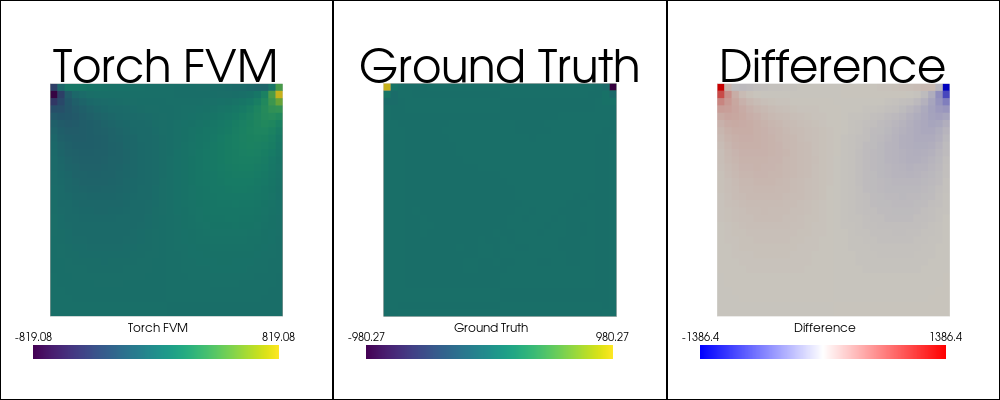

In [131]:
mesh.correction_method = None
mesh.implicit_orthogonality = True

lapU1 = mesh.calculate_laplacian(U_gt, field_type='U')*0.01
names = ['LapU', 'LapV']
i = 1
plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                prediction=lapU1.squeeze(0).squeeze(0).numpy(),
                ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                i=i, interactive = True, 
                point_label=False,
                #clims3=[-0.1, 0.1]
                )

mesh.correction_method = None
mesh.implicit_orthogonality = False  
lapU2 = mesh.calculate_laplacian(U_gt, field_type='U')*0.01          
plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                prediction=lapU2.squeeze(0).squeeze(0).numpy(),
                ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                i=i, interactive = True, 
                point_label=False,
                #clims3=[-0.1, 0.1]
                )

plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                prediction=lapU1.squeeze(0).squeeze(0).numpy(),
                ground_truth = lapU2.squeeze(0).squeeze(0).numpy(),
                i=i, interactive = True, 
                point_label=False,
                #clims3=[-10, 10]
                )

Lets try divergence of the gradients

In [132]:
self = mesh 
field = gradU_pred
field_type = 'U'
grad_field=True

field_shape = field.shape
batch_size = field_shape[0]
time_size = field_shape[1]
channel_size = field_shape[-1]

lap_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)

face_values = self.interpolate_to_faces(field, field_type, grad_field, original_field=U_gt)
face_values = face_values.unflatten(dim=-1, sizes=(mesh.mesh.dim, mesh.mesh.dim))
print(face_values.shape)
face_flux_mag = torch.einsum('btfde,fe->btfd', face_values, self.mesh.face_areas)
divergence  = face_flux_mag # no advecting by U here

idx = self.mesh.internal_faces
div_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
div_field.index_add_(2, self.mesh.face_owners, divergence)
div_field.index_add_(2, self.mesh.face_neighbors[idx], -divergence[...,idx,:])
div_field /= self.mesh.cell_volumes.reshape(1,1,-1,1)

torch.Size([1, 1, 4160, 3, 3])


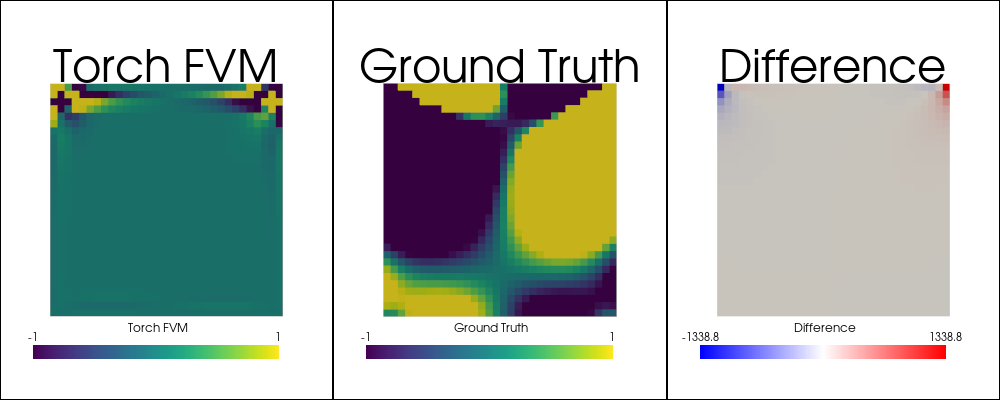

In [133]:
plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',
                prediction=div_field.squeeze(0).squeeze(0).numpy()*0.01,
                ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                i=i, interactive = True, 
                point_label=False,
                clims=[-1, 1],
                clims2=[-1, 1]
                )

This is essentially the explicit version. What could be producing an error is the velocity at the lid. Lets look at the internal field error

## Manual Laplacian

In [17]:
torch.isnan(implicit_face_gradients).any()
torch.where(self.d_mag == 0)[0].any()

tensor(True)

In [3]:
self = mesh 
field = U_gt
field_type = 'U'
grad_field=False

# Get field shape
field_shape = field.shape
batch_size = field_shape[0]
time_size = field_shape[1]
channel_size = field_shape[-1]

# initialize laplacian field
lap_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)

# Interpolate field to face centers
face_values = self.interpolate_to_faces(field, field_type)

# Calculate Implicit Face Gradients using First Order Appoximation
implicit_face_gradients = torch.zeros((batch_size, time_size, self.mesh.num_faces, channel_size), dtype=field.dtype, device=field.device)
implicit_face_gradients[:,:,self.mesh.internal_faces,:] = field[:,:,self.mesh.face_neighbors[self.mesh.internal_faces], :] - field[:,:,self.mesh.face_owners[self.mesh.internal_faces],:]
if self.boundaries is not None:
    for patch_name, patch_faces in self.mesh.patch_face_keys.items():
        if patch_name == 'frontAndBack':
            implicit_face_gradients[:,:,patch_faces,:] = 0
        if patch_name == 'movingWall':
            boundary_value = torch.tensor([1.0,0.0,0.0], dtype=torch.float32).reshape(1,1,1,-1)
            field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
            #implicit_face_gradients[:,:,patch_faces,:] = torch.einsum('btfd,fe->btfed',(boundary_value-field_value), self.mesh.face_normal_unit_vectors[patch_faces,:])/self.d_mag[patch_faces].reshape(1,1,-1,1, 1)
            #implicit_face_gradients[:,:,patch_faces,:] = torch.einsum('btfd,fd->btfd',(boundary_value-field_value), self.mesh.face_normal_unit_vectors[patch_faces,:])
            implicit_face_gradients[:,:,patch_faces,:] = (boundary_value-field_value)

            #raise KeyboardInterrupt
        if patch_name == 'fixedWalls':
            boundary_value = torch.tensor([0,0,0], dtype=torch.float32).reshape(1,1,1,-1)
            field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
            # print((boundary_value-field_value).shape,
            #       self.mesh.face_normal_unit_vectors[patch_faces,:].shape)
            # face_gradients = torch.einsum('btfd,fe->btfed',(boundary_value-field_value), self.mesh.face_normal_unit_vectors[patch_faces,:])#/self.d_mag[patch_faces].reshape(1,1,-1,1,1)
            # face_gradients_tangential_zerod = torch.einsum('btfde,fe->btfd', face_gradients, self.mesh.face_normal_unit_vectors[patch_faces,:])
            # implicit_face_gradients[:,:,patch_faces,:] = face_gradients_tangential_zerod
            #implicit_face_gradients[:,:,patch_faces,:] = torch.einsum('btfd,fd->btfd',(-field_value)
 

#implicit_face_gradients[:,:,self.mesh.boundary_faces,:] = face_values[:,:,self.mesh.boundary_faces, :] - field[:,:,self.mesh.face_owners[self.mesh.boundary_faces],:]
implicit_face_gradients/= self.d_mag.reshape(1, 1, -1, 1)

# Calculate Explicit Face Gradients using Gauss-Green theorem
gradients = self.calculate_gradients(field, field_type, face_values=face_values)
explicit_face_gradients = self.interpolate_to_faces(gradients, field_type, grad_field_f=True, original_field=field)
explicit_face_gradients = explicit_face_gradients.unflatten(dim=-1, sizes=(self.mesh.dim, self.mesh.dim))
    
# Implicit has an approximation for grad(U) dot Delta
#orth_diffusion = torch.einsum('btfd,fd->btfd', implicit_face_gradients, self.delta_mag) * self.mesh.face_areas_mag.reshape(1, 1, -1, 1)
orth_diffusion = implicit_face_gradients * (self.delta_mag * self.mesh.face_areas_mag).reshape(1, 1, -1, 1)
if self.boundaries is not None:
    for patch_name, patch_faces in self.mesh.patch_face_keys.items():
        if patch_name == 'frontAndBack':
            pass
        if patch_name == 'movingWall':
            field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
            ugrad = (torch.tensor([1.0,0.0,0.0], dtype=torch.float32).reshape(1,1,1,-1)-field_value)/self.d_mag[patch_faces].reshape(1, 1, -1, 1)
            orth_diffusion[:,:,patch_faces,:] = ugrad*self.mesh.face_areas_mag[patch_faces].reshape(1, 1, -1, 1) #torch.einsum('btfd,fd->btfd',, self.mesh.face_areas)
            #orth_diffusion[:,:,patch_faces,:] = torch.einsum('btfd,fd->btfd',(torch.tensor([1.0,0.0,0.0], dtype=torch.float32).reshape(1,1,1,-1)-field_value)/self.d_mag.reshape(1, 1, -1, 1), self.mesh.face_areas)
        if patch_name == 'fixedWalls':
            field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
            ugrad = (-field_value)/self.d_mag[patch_faces].reshape(1, 1, -1, 1)
            orth_diffusion[:,:,patch_faces,:] = ugrad*self.mesh.face_areas_mag[patch_faces].reshape(1, 1, -1, 1) #torch.einsum('btfd,fd->btfd',, self.mesh.face_areas)
        

# orth_diffusion = torch.einsum('btfd,fd->btfd', implicit_face_gradients, self.mesh.face_areas)# * self.mesh.face_areas_mag.reshape(1, 1, -1, 1)
# orth_diffusion1 = torch.einsum('btfd,fe->btfde', implicit_face_gradients, self.mesh.face_normal_unit_vectors)
# orth_diffusion = torch.einsum('btfed,fd->btfe', orth_diffusion1, self.mesh.face_areas)


face_diffusion = orth_diffusion

# Add to owner/neighbour cells
idx = self.mesh.internal_faces
lap_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
lap_field.index_add_(2, self.mesh.face_owners, face_diffusion)
lap_field.index_add_(2, self.mesh.face_neighbors[idx], -face_diffusion[...,idx,:])
lap_field /= self.mesh.cell_volumes.reshape(1,1,-1,1)

In [ ]:
class Laplacian_Operator():

    @staticmethod
    def caclulate(self, field, field_type = 'U', correction_method=None):
        # initialize laplacian field
        lap_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)

        lap_field = Laplacian_Operator.internal_flux(self, lap_field, field, field_type)
        lap_field = Laplacian_Operator.boundary_flux(self, lap_field, field, field_type, orth_vector=self.d_mag)
        lap_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)

        if correction_method is not None:
            correction_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)



        return lap_field
    
    @staticmethod
    def internal_flux(self, lap_field, field, field_type, orth_vector, ):
        idx = self.mesh.internal_faces

        # Orthogonal
        if implicit:
            face_gradients = field[:,:,self.mesh.face_neighbors[idx], :] - field[:,:,self.mesh.face_owners[idx],:]
            orth_diffusion = face_gradients * (self.delta_mag * self.mesh.face_areas_mag).reshape(1, 1, -1, 1)
        else:
            face_gradients = '?'



        lap_field.index_add_(2, self.mesh.face_owners, orth_diffusion)
        lap_field.index_add_(2, self.mesh.face_neighbors[idx], -orth_diffusion[...,idx,:])

        return lap_field
    
    @staticmethod
    def boundary_flux(self, lap_field, field, field_type, orth_vector=None,):
        for patch_name, patch_faces in self.mesh.patch_face_keys.items():
            patch_type = self.bc_conditions[field_type][patch_name]['type']
            if patch_type in ('empty', 'symmetryPlane', 'zeroGradient'):
                continue
            else:
                if orth_vector is None:
                    orth_coefficient = (self.mesh.face_areas_mag[patch_faces]/self.d_mag[patch_faces])
                elif orth_vector == 'Delta':
                    orth_coefficient = torch.einsum('fd,fd -> f', self.mesh.face_normal_unit_vectors[patch_faces], self.delta[patch_faces])
                    orth_coefficient *= self.mesh.face_areas_mag[patch_faces]/(self.delta_mag[patch_faces]**2)
                elif orth_vector == 'k':
                    orth_coefficient = torch.einsum('fd,fd -> f', self.mesh.face_normal_unit_vectors[patch_faces], self.k_vector[patch_faces])
                    orth_coefficient *= self.mesh.face_areas_mag[patch_faces]/(self.k_vector_mag[patch_faces]**2)
                else:
                    raise KeyboardInterrupt(f'Orthogonal Vector string must be either "Delta", "k" or None. {orth_vector} is not accepted')

            if patch_type == 'fixedValue':

                field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
                bc_value = torch.tensor(self.bc_conditions[field_type][patch_name]['value'], dtype=self.dtype, device=self.device)
                diffusion = (bc_value.reshape(1,1,1,-1)-field_value)*orth_coefficient.reshape(1,1,1,-1)

            elif patch_type == 'noSlip':
                field_value = field[:,:,self.mesh.face_owners[patch_faces],:]
                diffusion = (-field_value)*orth_coefficient.reshape(1,1,1,-1)

            else:
                raise NotImplementedError(f'patch type {patch_type} not implemented')
            
            lap_field.index_add_(2, self.mesh.face_owners[patch_faces], diffusion)
        
        return lap_field

In [27]:
lap_field2 = Laplacian_Operator.caclulate(mesh,U_gt)

NameError: name 'batch_size' is not defined

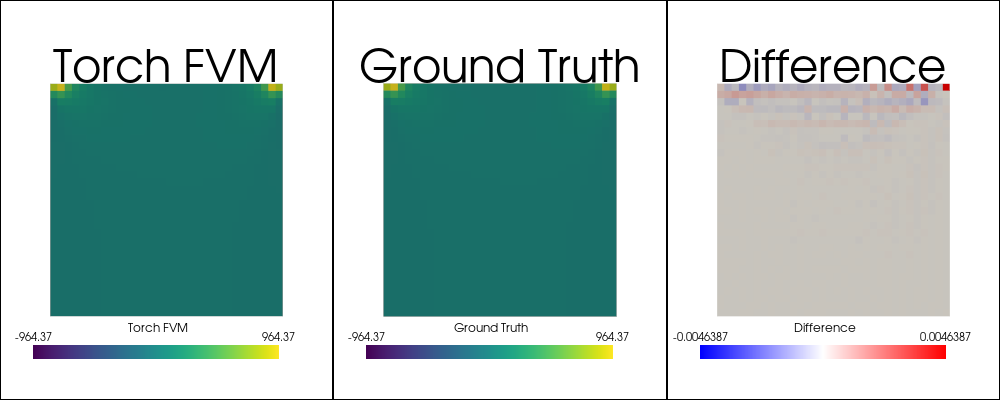

In [4]:
names = ['LapU','LapV']
plot_comparison(vtk_mesh, None, f'Uncorrected_{names[0]}',
                prediction=lap_field.squeeze(0).squeeze(0).numpy()*0.01,
                ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                i=0, interactive = True, 
                point_label=False,
                #clims=[-100,100],
                #clims2=[-100,100],
                #clims3=[-1, 1]
                )

In [136]:
torch.tensor([1,0,0], dtype=torch.float32).reshape(1,1,1,-1)[...,0]

tensor([[[1.]]])